# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [ ]:
import PIL
print(PIL.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
!unzip -q -o /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте или как получится
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")
DEVICE

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

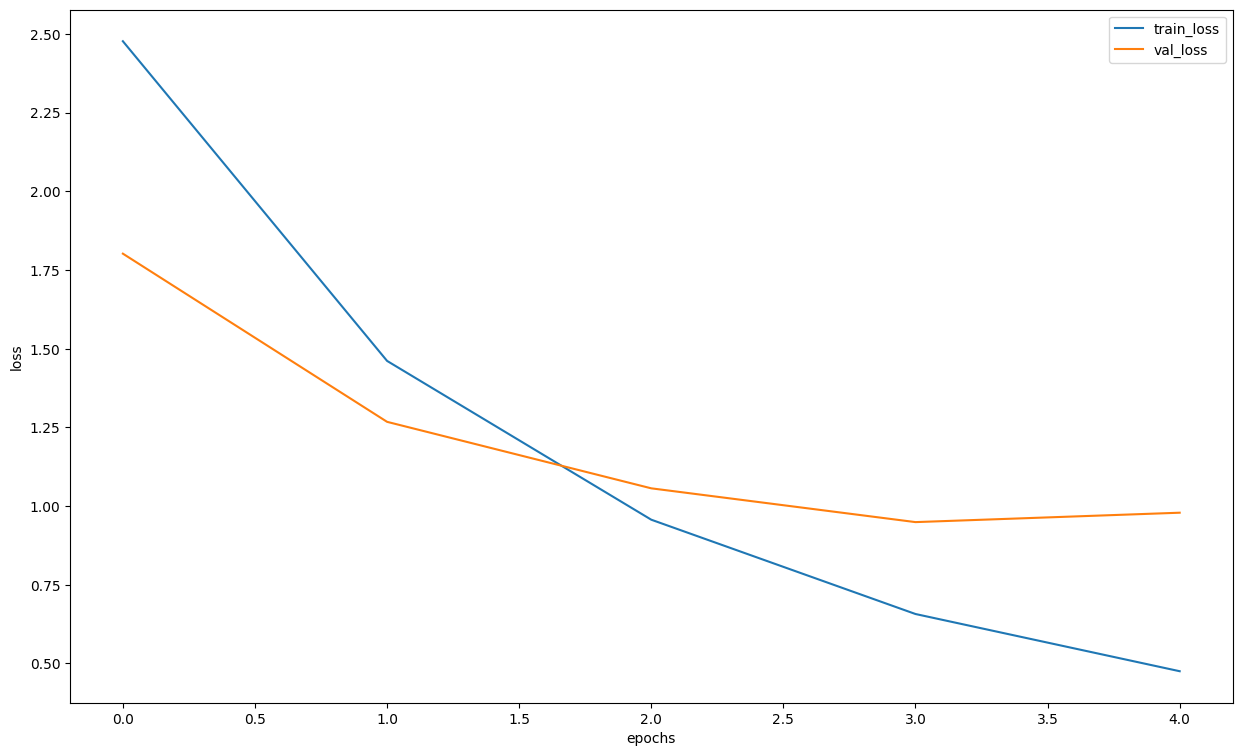

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.8


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q -n /content/drive/MyDrive/journey-springfield.zip

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте или как получится
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")
DEVICE

In [ ]:
# Кастомная реализация F1 Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class F1Loss(nn.Module):
    def __init__(self, eps=1e-7):
        super(F1Loss, self).__init__()
        self.eps = eps

    def forward(self, outputs, targets):
        # Преобразуем логиты в вероятности
        probabilities = F.softmax(outputs, dim=1)

        # Создаем one-hot представление меток
        targets_one_hot = F.one_hot(targets, num_classes=outputs.size(1)).float()

        # Вычисляем True Positive, Precision, Recall
        tp = (probabilities * targets_one_hot).sum(dim=0)
        precision = tp / (probabilities.sum(dim=0) + self.eps)
        recall = tp / (targets_one_hot.sum(dim=0) + self.eps)

        # F1-метрика
        f1 = 2 * (precision * recall) / (precision + recall + self.eps)
        f1_loss = 1 - f1.mean()  # Средний F1 Loss

        return f1_loss

In [ ]:
# На лекциях и семинарах рассказали, что многое уже было сделано до нас.
# Определимся с готовой архитектурой. В папирах частенько пишут про ResNet.
# Пришло время познакомиться поближе

import torch
from torchvision.models import resnet50
import torchmetrics
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Параметры обучения
num_epochs = 10
batch_size = 128
lr = 1e-3
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Попробуем предварительно докинуть веса предобученные на ImageNet
model = resnet50(weights="IMAGENET1K_V2")

# Заменяем последний полносвязный слой для соответствия количеству классов в нашем датасете
num_classes = 42
# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(model.fc.in_features, 512),  # Усложняем классификатор
#     torch.nn.ReLU(),                             # Нелинейность
#     torch.nn.Dropout(0.5),                       # Dropout для регуляризации
#     torch.nn.Linear(512, num_classes)            # Финальный слой
# )
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False
# Размораживаем 2 последних слоя
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True


# Переносим модель на устройство
model.to(device)

# Печать обучаемых параметров
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} will be trained.")

# Определяем функцию потерь, оптимизатор и метрику оценки
# criterion = F1Loss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, min_lr=1e-6, verbose=True)
f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes).to(device)

In [ ]:
# Для воспроизводимисти результатов зафиксируем все возможные сиды
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import pickle
from torchvision import transforms
from collections import Counter

import pickle
import numpy as np
from skimage import io

from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Готовим датку
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # Трансформации
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])

        x = self._prepare_sample(x)
        # x = Image.fromarray(x)  # Преобразуем numpy обратно в PIL.Image

        if self.transform:
            x = self.transform(x)
        else:
            x = transforms.ToTensor()(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        # image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image  # Просто возвращаем изображение PIL

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)
# train_files, val_files = train_test_split(train_val_files, test_size=0.01, stratify=train_val_labels)

train_val_labels = [path.parent.name for path in train_val_files]
label_counts = Counter(train_val_labels)
print(f"label_counts: {label_counts}")

# Трансформ с аугментациями для трейна
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),  # Случайное кадрирование
    transforms.RandomHorizontalFlip(),  # Горизонтальное отражение
    transforms.RandomRotation(degrees=15),  # Случайное вращение
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Случайное смещение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Цветовая аугментация
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Cutout
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])
# Трансформ для валидации и теста
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Приведение к фиксированному размеру
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

train_dataset_aug = SimpsonsDataset(train_files, mode='train', transform=transform_train)
train_dataset = SimpsonsDataset(train_files, mode='train', transform=transform_val)
train_dataset = ConcatDataset([train_dataset_aug, train_dataset])
print(f"Длина объединенного датасета: {len(train_dataset)}")
val_dataset = SimpsonsDataset(val_files, mode='val', transform=transform_val)
test_dataset = SimpsonsDataset(test_files, mode="test", transform=transform_val)

In [ ]:
image, label = train_dataset[0]
print(f"Тип данных изображения: {type(image)}")
print(f"Тип данных метки: {type(label)}")
print(f"Размерность изображения: {image.shape}")

In [ ]:
# Готовим тренировочный, валидационный и DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
import shutil
# Очищаем папку
# shutil.rmtree("runs/experiment_1")
# Запускаем TensorBoard в Google Colab
writer = SummaryWriter(log_dir="runs/experiment_1")
%load_ext tensorboard
%tensorboard --logdir=runs/experiment_1

In [ ]:
best_f1 = 0.0
patience = 3
epochs_no_improve = 0

# Цикл обучения
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Train", leave=False, dynamic_ncols=True):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False, dynamic_ncols=True):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.append(predictions)
            all_labels.append(labels)

    # Собираем данные и подсчитываем F1
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    f1_score = f1(all_predictions, all_labels)

    scheduler.step(f1_score)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch + 1)
    writer.add_scalar('Metrics/F1', f1_score, epoch + 1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1-score: {f1_score:.4f}")

    # Сохранение лучшей модели
    if f1_score > best_f1:
        best_f1 = f1_score
        epochs_no_improve = 0
        torch.save(model.state_dict(), f'/content/drive/MyDrive/simpsons_resnet50_difficultFC_epoch{epoch+1}_f1_{f1_score:.4f}.pth')
    if epochs_no_improve == patience:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

writer.close()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.9968, Val Loss: 0.2482, F1-score: 0.9385


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.4901, Val Loss: 0.1950, F1-score: 0.9526


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.4051, Val Loss: 0.1452, F1-score: 0.9631


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.3523, Val Loss: 0.1739, F1-score: 0.9570


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.3338, Val Loss: 0.1548, F1-score: 0.9662


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.3170, Val Loss: 0.1483, F1-score: 0.9635


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.2996, Val Loss: 0.1488, F1-score: 0.9664


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.3029, Val Loss: 0.1376, F1-score: 0.9681


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.2862, Val Loss: 0.1309, F1-score: 0.9690


Train:   0%|          | 0/246 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.2767, Val Loss: 0.1502, F1-score: 0.9675


In [ ]:
# Загружаем свои веса
weights_path = "/content/simpsons_resnet50_epoch8_f1_0.9708.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)
model.eval()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simpsons_resnet50_epoch8.csv', index=False)

In [ ]:
# В ходе экспериментов я тестировала различные архитектуры и подходы для решения задачи. Вот основные шаги и выводы:

#     1. Модель:
#         * Пробовала ResNet18, ResNet34 и ResNet50.
#           Наилучший результат показала ResNet50.
#         * Тестировала модели с предобученными весами на ImageNet и с "пустыми" весами.
#           Лучший результат был достигнут при использовании весов IMAGENET1K_V2.

#     2. Функция потерь (criterion):
#         * Экспериментировала с кастомной функцией F1Loss и стандартной CrossEntropyLoss.
#           Использование F1Loss оказалось неэффективным, так как она не подходит для работы с вероятностями напрямую.
#           CrossEntropyLoss обеспечила стабильное обучение и была оставлена в качестве финального варианта.

#     3. Последний слой:
#         Пробовала два варианта:
#             * Простой линейный слой.
#             * Более сложный вариант: два линейных слоя с дропаутом и нелинейностью ReLU между ними.
#         Наилучшие результаты показал простой линейный слой.

#     4. Заморозка слоёв:
#         Экспериментировала с заморозкой:
#             * Всех слоёв, кроме последнего.
#             * Всех слоёв, кроме двух последних.
#             * Всех слоёв, кроме трёх последних.
#         Наилучший результат был достигнут при заморозке всех слоёв, кроме двух последних.

#     5. Данные и аугментации:
#         * Использовала тренировочный датасет без аугментаций.
#         * Пробовала добавлять аугментации:
#             - На все семплы.
#             - Докидывать аугментированные копии к оригинальным семплам.
#         Наилучший результат показал второй подход, когда к оригинальным данным добавлялись их аугментированные версии.

#     6. Гиперпараметры:
#         Наиболее удачными значениями стали:
#             * Learning rate (lr): 1e-3.
#             * Weight decay: 1e-4.

#     7. Scheduler и регуляризация L2:
#         Добавила scheduler и регуляризацию L2.
#         Влияние этих элементов сложно оценить, так как они были добавлены уже на этапе устранения других проблем. Однако их использование рекомендуется для улучшения устойчивости обучения.

In [ ]:
################################################################################

#                     Elena_Seliverstova_967285686

################################################################################

In [ ]:
# На всякий случай. Вот мои сабмиты для более сложного и простого последнего слоя

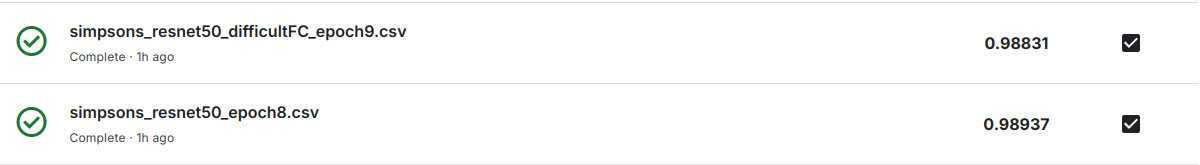

In [ ]:
# А вот я в лидерборде

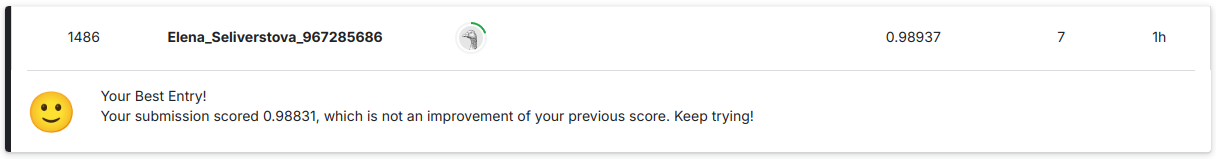